https://eli5.readthedocs.io/en/latest/_modules/eli5/sklearn/explain_weights.html
https://eli5.readthedocs.io/en/latest/tutorials/xgboost-titanic.html#explaining-predictions

Prøv at tage, f. eks., Vinterraps mod alle andre (dvs. binær klassifikation), og se hvilke datoer der gør at vinterraps er let at få øje på.

Prøv også at kigge på https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html.

In [56]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from pathlib import Path
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split         # Split data into train and test set

from utils import evaluate_classifier, get_sklearn_df 

# Allow more rows to be printed to investigate feature importance
pd.set_option('display.max_rows', 300)

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 28.3 ms


In [5]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc') ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 67312, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 62131272 63199619
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 205 ms


In [6]:
ds.close()

time: 20.2 ms


In [310]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 11.4 s


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/opt/conda/lib/python3.7/site-packages/scipy/optimize/linesearch.py:3

Training time: 0.8212 s
Prediction time: 0.0006 s

Report:

Train accuracy: 0.9832
Test accuracy: 0.9833

               precision    recall  f1-score   support

      Vårbyg       0.97      0.97      0.97      1200
 Vinterhvede       0.98      0.99      0.98      1107
    Silomajs       0.98      0.98      0.98      1447
  Vinterraps       1.00      0.99      1.00      1086

    accuracy                           0.98      4840
   macro avg       0.98      0.98      0.98      4840
weighted avg       0.98      0.98      0.98      4840



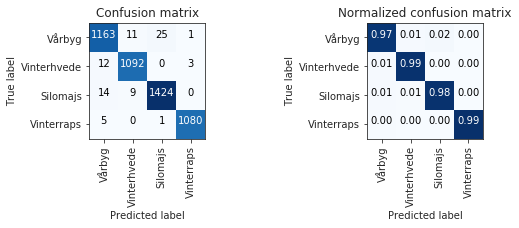

time: 12.9 s


In [327]:
df_sklearn = get_sklearn_df(polygons_year=2019, 
                            satellite_dates=slice('2019-01-01', '2019-12-31'), 
                            fields='all', 
                            satellite='S1B', 
                            polarization='all',
                            crop_type='all',
                            netcdf_path=netcdf_path)
    
#df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
#                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps'])]
crop_codes = df_sklearn['afgkode'].unique()
mapping_dict = {}
class_names = [] 

for i, crop_code in enumerate(crop_codes):
    mapping_dict[crop_code] = i
    crop_type = df_sklearn[df_sklearn['afgkode'] == crop_code].head(1)['afgroede'].values[0]
    class_names.append(crop_type)

df_sklearn_remapped = df_sklearn.copy()
df_sklearn_remapped['afgkode'] = df_sklearn_remapped['afgkode'].map(mapping_dict)
#print(f"Crop types: {class_names}")

array = df_sklearn_remapped.values

# Define the independent variables as features.
X = np.float32(array[:,3:])  # The features 

# Define the target (dependent) variable as labels.
y = np.int8(array[:,1])  # The column 'afgkode'

# Create a train/test split using 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#print(f"Train samples:      {len(y_train)}")
#print(f"Test samples:       {len(y_test)}")
#print(f"Number of features: {len(X[0,:])}")

from sklearn.linear_model import LogisticRegression          

# Instantiate classifier.
clf = LogisticRegression(solver='newton-cg', max_iter=100)
clf_trained, _ = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True)

In [328]:
try:
    from eli5 import show_weights
except:
    !conda install -y eli5

time: 22.6 ms


In [329]:
import eli5
from eli5.sklearn import PermutationImportance

feature_names = df_sklearn.columns[3:]
perm = PermutationImportance(clf, random_state=1).fit(X_test, y_test)
eli5.explain_weights(clf, feature_names=list(feature_names), target_names=class_names)
# Look at https://eli5.readthedocs.io/en/latest/autodocs/formatters.html#eli5.formatters.html.format_as_html

# IMPORTANT: LOOK HERE TO FIND IMPORTANCE FOR INDIVIDUAL CLASSES:
#            https://stackoverflow.com/questions/59245580/eli5-explain-weights-does-not-returns-feature-importance-for-each-class-with-skl

Explanation(estimator="LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n                   intercept_scaling=1, l1_ratio=None, max_iter=100,\n                   multi_class='warn', n_jobs=None, penalty='l2',\n                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,\n                   warm_start=False)", description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='Vårbyg', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='2019-05-16_VV', weight=1.8498544, std=None, value=None), FeatureWeight(feature='2019-05-04_VV-VH', weight=0.7841868, std=None, value=None), FeatureWeight(feature='2019-06-09_VH', weight=0.6237463, std=None, value=None), FeatureWeight(feature='2019-05-28_VV', weight=0.5763656, std=None, value=None), FeatureWeight(feature='2019-05-16_VH', weight=0.5590778, std=None, value=None), FeatureWeight(feature='2019-05-16_VV-VH', weight=0.55662405, std=None, value=None), FeatureWeight(feature='2019-07-15_VV-VH', weight=0.49287397, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-3.1887286, std=None, value=None), FeatureWeight(feature='2019-06-09_VV-VH', weight=-1.2722797, std=None, value=None), FeatureWeight(feature='2019-07-03_VV', weight=-0.9219688, std=None, value=None), FeatureWeight(feature='2019-06-21_VV', weight=-0.7600992, std=None, value=None), FeatureWeight(feature='2019-05-04_VH', weight=-0.72034395, std=None, value=None), FeatureWeight(feature='2019-04-22_VH', weight=-0.635531, std=None, value=None), FeatureWeight(feature='2019-07-03_VH', weight=-0.6024519, std=None, value=None), FeatureWeight(feature='2019-01-16_VV', weight=-0.53840166, std=None, value=None), FeatureWeight(feature='2019-06-09_VV', weight=-0.52743906, std=None, value=None), FeatureWeight(feature='2019-08-08_VV', weight=-0.51551193, std=None, value=None), FeatureWeight(feature='2019-07-03_VV-VH', weight=-0.5096331, std=None, value=None), FeatureWeight(feature='2019-04-10_VH', weight=-0.5012378, std=None, value=None), FeatureWeight(feature='2019-06-21_VV-VH', weight=-0.4964149, std=None, value=None)], pos_remaining=27, neg_remaining=32), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target='Vinterhvede', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='2019-01-16_VV', weight=0.9498313, std=None, value=None), FeatureWeight(feature='2019-04-22_VH', weight=0.8543367, std=None, value=None), FeatureWeight(feature='2019-05-04_VH', weight=0.64894545, std=None, value=None), FeatureWeight(feature='2019-04-10_VV-VH', weight=0.6111899, std=None, value=None), FeatureWeight(feature='2019-10-07_VV', weight=0.50023216, std=None, value=None), FeatureWeight(feature='2019-03-29_VH', weight=0.44744742, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-4.8143325, std=None, value=None), FeatureWeight(feature='2019-05-16_VV', weight=-1.5454156, std=None, value=None), FeatureWeight(feature='2019-05-04_VV-VH', weight=-1.2436987, std=None, value=None), FeatureWeight(feature='2019-06-09_VH', weight=-1.2207249, std=None, value=None), FeatureWeight(feature='2019-05-16_VV-VH', weight=-1.1660187, std=None, value=None), FeatureWeight(feature='2019-04-22_VV-VH', weight=-1.0319713, std=None, value=None), FeatureWeight(feature='2019-06-09_VV', weight=-1.0061787, std=None, value=None), FeatureWeight(feature='2019-07-03_VV', weight=-0.61468786, std=None, value=None), FeatureWeight(feature='2019-07-03_

time: 378 ms


In [330]:
df_explanation = eli5.formatters.as_dataframe.explain_weights_df(perm, feature_names=list(feature_names))
df_explanation = df_explanation.sort_values(by=['feature'])
df_explanation['polarization'] = ''
features = df_explanation['feature'].unique()
for feature in features:
    if feature[-5:] == 'VV-VH':
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV-VH'
        df_explanation = df_explanation.replace(feature, feature[:-6])
    elif feature[-2:] == 'VV':
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV'
        df_explanation = df_explanation.replace(feature, feature[:-3])
    else:
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VH'
        df_explanation = df_explanation.replace(feature, feature[:-3])
        
# OLD CODE:
#df_explanation_vh = df_explanation.iloc[::3]
#df_explanation_vh['polarization'] = 'VH'
#df_explanation_vh['feature'] = df_explanation_vh['feature'].map(lambda x: str(x)[:-3])
#df_explanation_vv = df_explanation.iloc[1::3]
#df_explanation_vv['polarization'] = 'VV'
#df_explanation_vv['feature'] = df_explanation_vv['feature'].map(lambda x: str(x)[:-3])
#df_explanation_vvvh = df_explanation.iloc[2::3]
#df_explanation_vvvh['polarization'] = 'VV-VH'
#df_explanation_vvvh['feature'] = df_explanation_vvvh['feature'].map(lambda x: str(x)[:-6])
#df_explanation = pd.concat([df_explanation_vh, df_explanation_vv, df_explanation_vvvh])

time: 274 ms


In [331]:
df_explanation.head(3)

,feature,weight,std,polarization
65,2019-01-04,-0.000124,0.000101,VH
33,2019-01-04,0.001116,0.000482,VV
26,2019-01-04,0.001736,0.000336,VV-VH


time: 25.1 ms


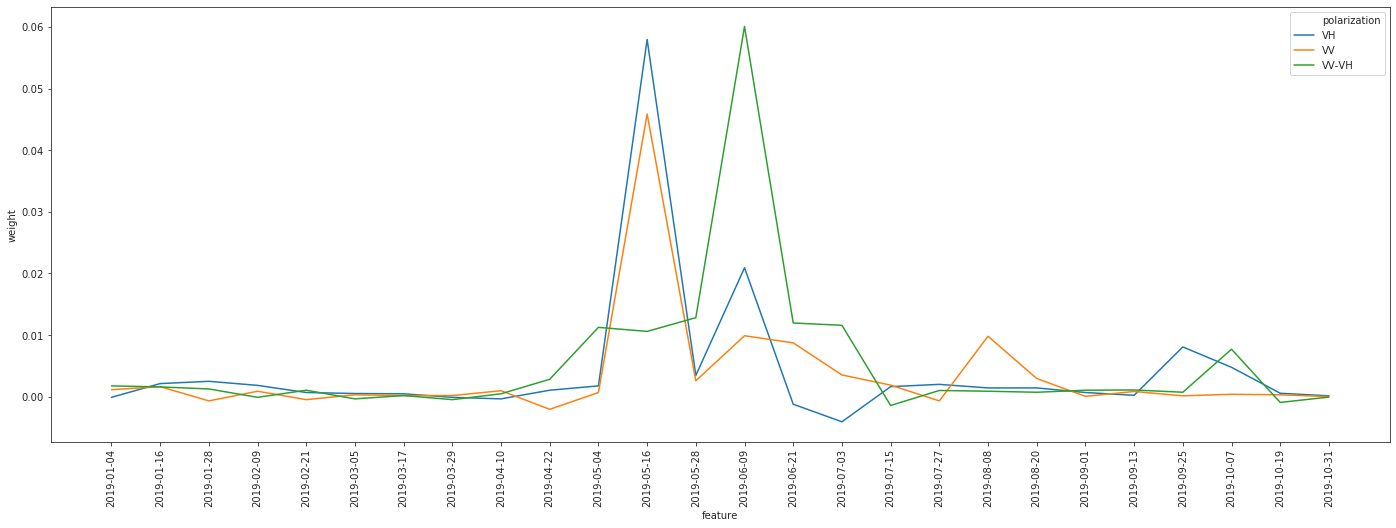

time: 342 ms


In [332]:
plt.figure(figsize=(24, 8))
plt.xticks(rotation=90, horizontalalignment='center')
ax = sns.lineplot(x='feature', y='weight', hue='polarization', data=df_explanation, ci='sd')

In [333]:
#df_explanation = eli5.formatters.as_dataframe.explain_prediction_df(perm, feature_names=list(feature_names))

time: 23.6 ms


In [334]:
# Show the calculated stds in the df as confidence interval on the plot
# https://stackoverflow.com/questions/58399030/make-a-seaborn-lineplot-with-standard-deviation-confidence-interval-specified-f
#lower_bound = [M_new_vec[i] - Sigma_new_vec[i] for i in range(len(M_new_vec))]
#upper_bound = [M_new_vec[i] + Sigma_new_vec[i] for i in range(len(M_new_vec))]
#plt.fill_between(x_axis, lower_bound, upper_bound, alpha=.3)

time: 21.1 ms


In [335]:
df_explanation = eli5.formatters.as_dataframe.explain_weights_df(clf, feature_names=list(feature_names), target_names=class_names)
df_explanation = df_explanation.sort_values(by=['feature', 'target'])
df_explanation['polarization'] = ''
features = df_explanation['feature'].unique()
features = features[:-1]  # The last features are the bias values
df_bias_values = df_explanation[df_explanation['feature'] == '<BIAS>']

df_explanation = df_explanation[df_explanation['feature'] != '<BIAS>']
for feature in features:
    if feature[-5:] == 'VV-VH':
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV-VH'
        df_explanation = df_explanation.replace(feature, feature[:-6])
    elif feature[-2:] == 'VV':
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV'
        df_explanation = df_explanation.replace(feature, feature[:-3])
    else:
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VH'
        df_explanation = df_explanation.replace(feature, feature[:-3])

time: 236 ms


In [336]:
df_bias_values

,target,feature,weight,polarization
236,Silomajs,<BIAS>,-3.325738,
157,Vinterhvede,<BIAS>,-4.814332,
315,Vinterraps,<BIAS>,-5.967107,
78,Vårbyg,<BIAS>,-3.188729,


time: 25.1 ms


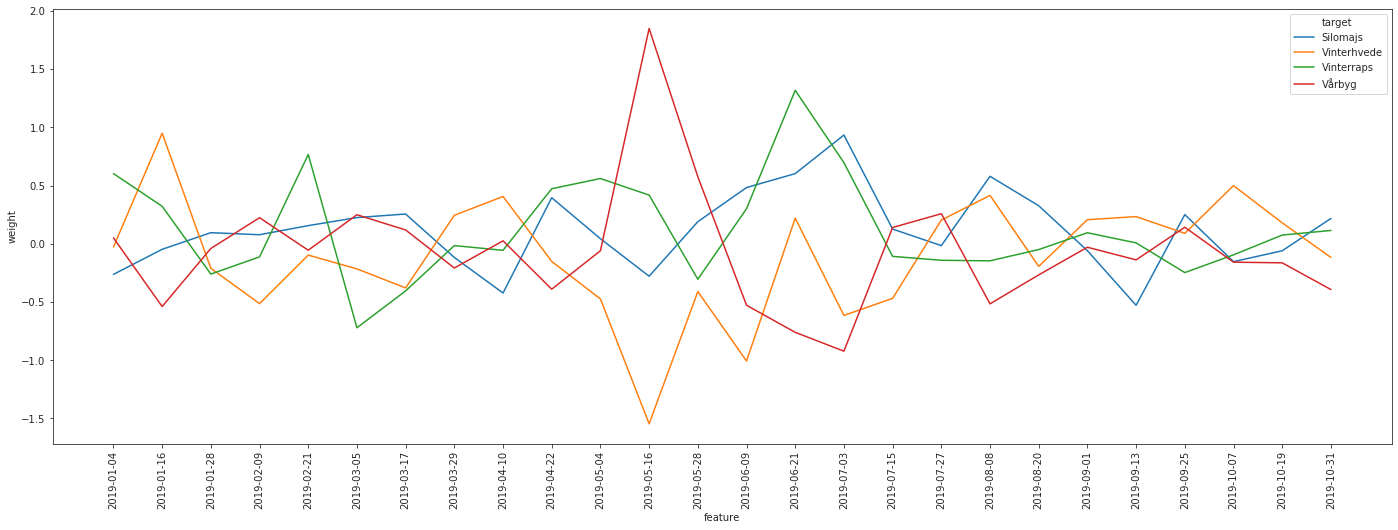

time: 383 ms


In [337]:
data = df_explanation[df_explanation['polarization'] == 'VV']
plt.figure(figsize=(24, 8))
plt.xticks(rotation=90, horizontalalignment='center')
ax = sns.lineplot(x='feature', y='weight', hue='target', data=data, ci='sd')